In [2]:
#import libraries
import pandas as pd
import numpy as np
import re
import copy
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import cross_validate

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from scipy.sparse import hstack
import re
from datetime import datetime


from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc, 
    precision_recall_curve, average_precision_score
)


import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sandr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sandr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Load 1/10th of dataset
total_rows = sum(1 for _ in open("Books_rating.csv")) - 1  
df = pd.read_csv("Books_rating.csv", nrows=total_rows // 15)
print(df.shape)  

(116925, 10)


In [4]:
#check structure 
df.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


In [5]:
#Check empty values
print(df.isnull().sum())

#remove empty columns
df = df.drop(columns=['Price', 'User_id', 'profileName'])

Id                         0
Title                      1
Price                 100403
User_id                22148
profileName            22153
review/helpfulness         0
review/score               0
review/time                0
review/summary            18
review/text                0
dtype: int64


In [6]:
#drop empty columns
df = df.dropna(subset=['review/summary'])
df = df.dropna(subset=['Title'])

#check empty columns
print(df.isnull().sum())

#check columns
print(df.shape)  

Id                    0
Title                 0
review/helpfulness    0
review/score          0
review/time           0
review/summary        0
review/text           0
dtype: int64
(116906, 7)


In [7]:
df.head()

,Id,Title,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


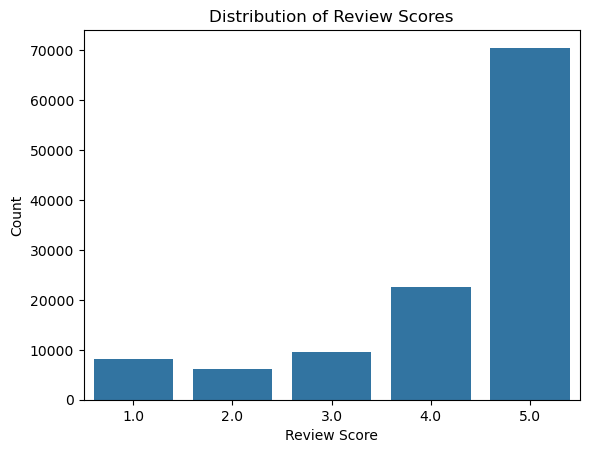

C:\Users\sandr\AppData\Local\Temp\ipykernel_30984\4151284923.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['review/score'], palette=colors)


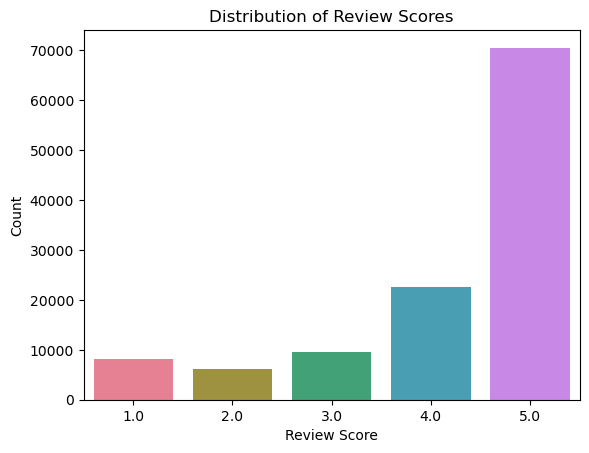

In [8]:
#distribution of review scores 
sns.countplot(x=df['review/score'])
plt.title("Distribution of Review Scores")
plt.xlabel("Review Score")
plt.ylabel("Count")
plt.show()


# Define a color palette
colors = sns.color_palette("husl", len(df['review/score'].unique()))

# Create the count plot with different colors for each bar
sns.countplot(x=df['review/score'], palette=colors)

plt.title("Distribution of Review Scores")
plt.xlabel("Review Score")
plt.ylabel("Count")
plt.show()

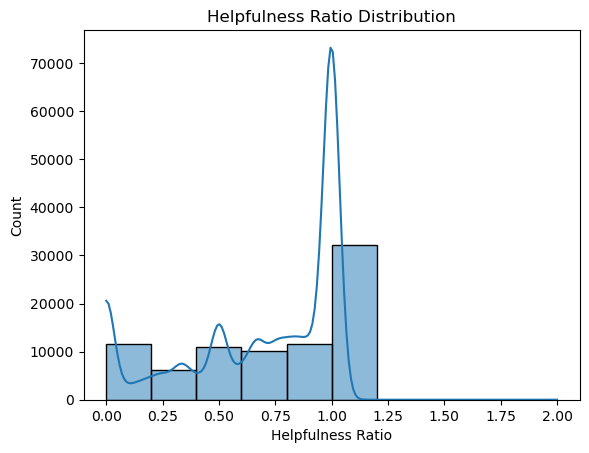

In [9]:
#helpfulness ratio 
df[['helpful_votes', 'total_votes']] = df['review/helpfulness'].str.split('/', expand=True).astype(float)
df['helpfulness_ratio'] = df['helpful_votes'] / df['total_votes']

# Plot helpfulness distribution
sns.histplot(df['helpfulness_ratio'].dropna(), bins=10, kde=True)
plt.title("Helpfulness Ratio Distribution")
plt.xlabel("Helpfulness Ratio")
plt.ylabel("Count")
plt.show()

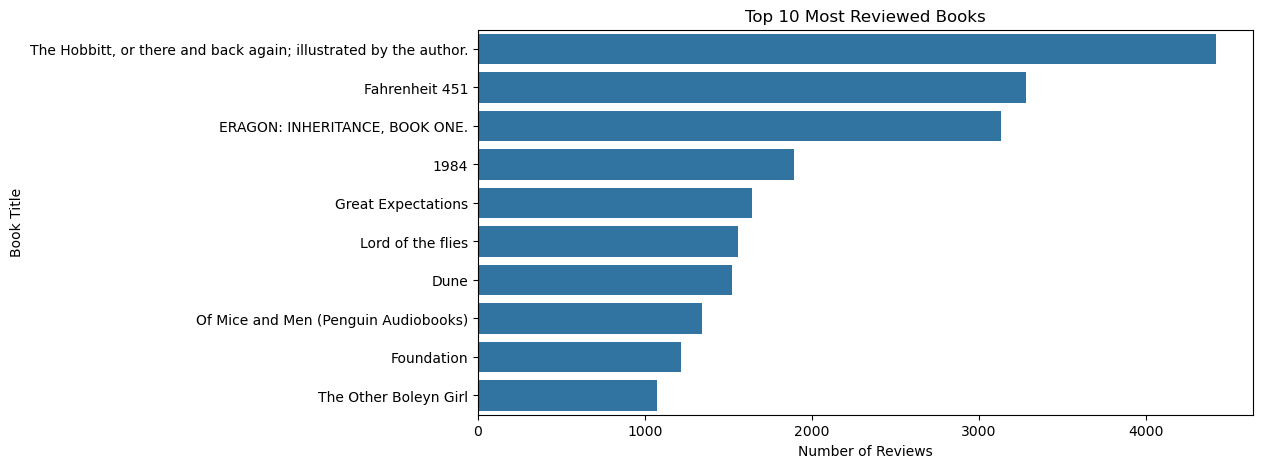

In [10]:
top_books = df['Title'].value_counts().head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_books.values, y=top_books.index)
plt.title("Top 10 Most Reviewed Books")
plt.xlabel("Number of Reviews")
plt.ylabel("Book Title")
plt.show()


C:\Users\sandr\AppData\Local\Temp\ipykernel_30984\3296695427.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_books.values, y=top_books.index, palette=colors)


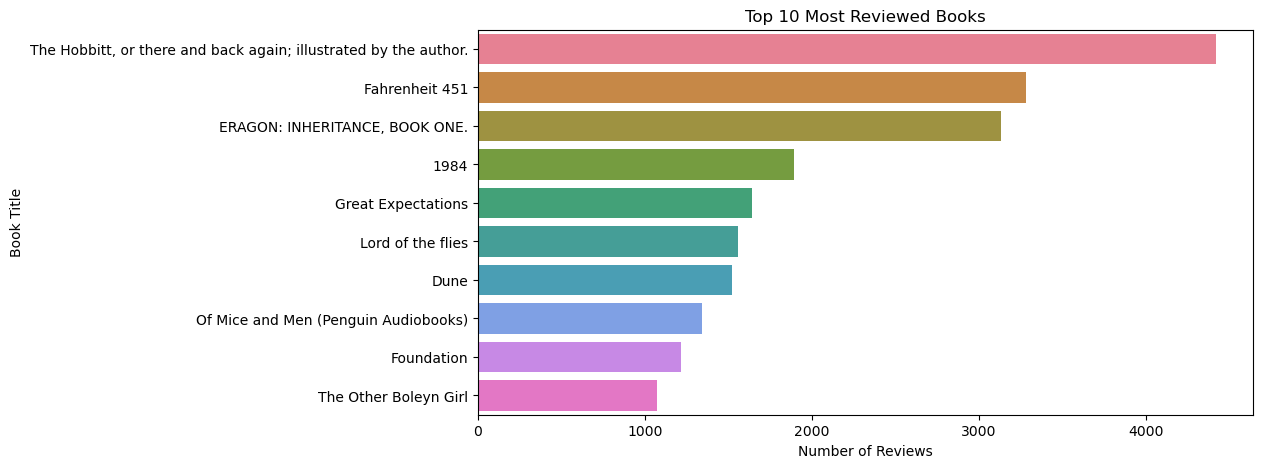

In [11]:
# Get the top 10 most reviewed books
top_books = df['Title'].value_counts().head(10)

# Create a color palette
colors = sns.color_palette("husl", len(top_books))  # "husl" provides vibrant, distinct colors

# Plot the bar chart with different colors
plt.figure(figsize=(10, 5))
sns.barplot(x=top_books.values, y=top_books.index, palette=colors)

# Add labels and title
plt.title("Top 10 Most Reviewed Books")
plt.xlabel("Number of Reviews")
plt.ylabel("Book Title")
plt.show()

In [12]:
!pip install textblob

import nltk
nltk.download('punkt')
from textblob import TextBlob

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sandr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


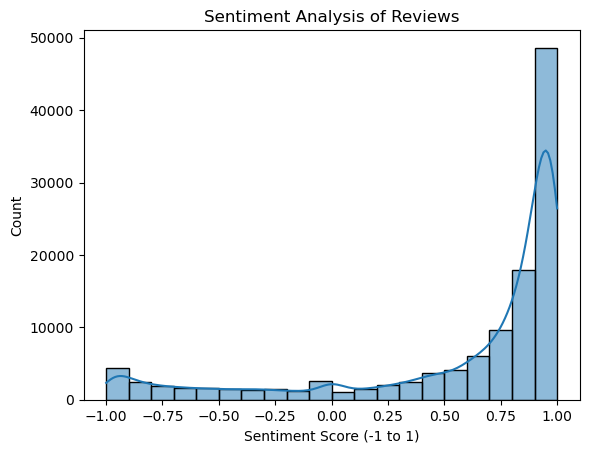

In [23]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
df['sentiment'] = df['review/text'].astype(str).apply(lambda x: sid.polarity_scores(x)['compound'])

# Sentiment Distribution
sns.histplot(df['sentiment'], bins=20, kde=True)
plt.title("Sentiment Analysis of Reviews")
plt.xlabel("Sentiment Score (-1 to 1)")
plt.ylabel("Count")
plt.show()

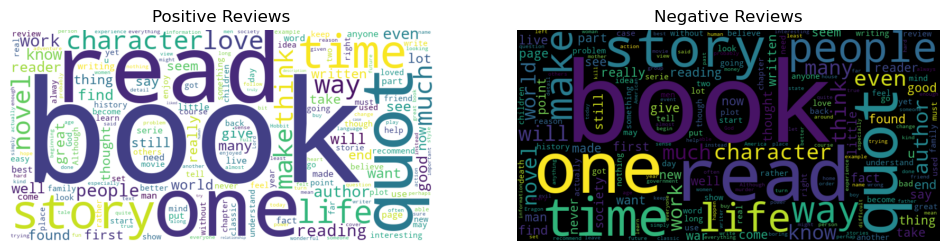

In [24]:
from wordcloud import WordCloud

positive_text = ' '.join(df[df['sentiment'] > 0]['review/text'].dropna())
negative_text = ' '.join(df[df['sentiment'] < 0]['review/text'].dropna())

wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wordcloud_neg = WordCloud(width=800, height=400, background_color='black').generate(negative_text)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis("off")
plt.title("Positive Reviews")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis("off")
plt.title("Negative Reviews")

plt.show()

C:\Users\sandr\AppData\Local\Temp\ipykernel_30984\1019397076.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.set_index('review/time')['Id'].resample('M').count().plot(figsize=(12, 6))


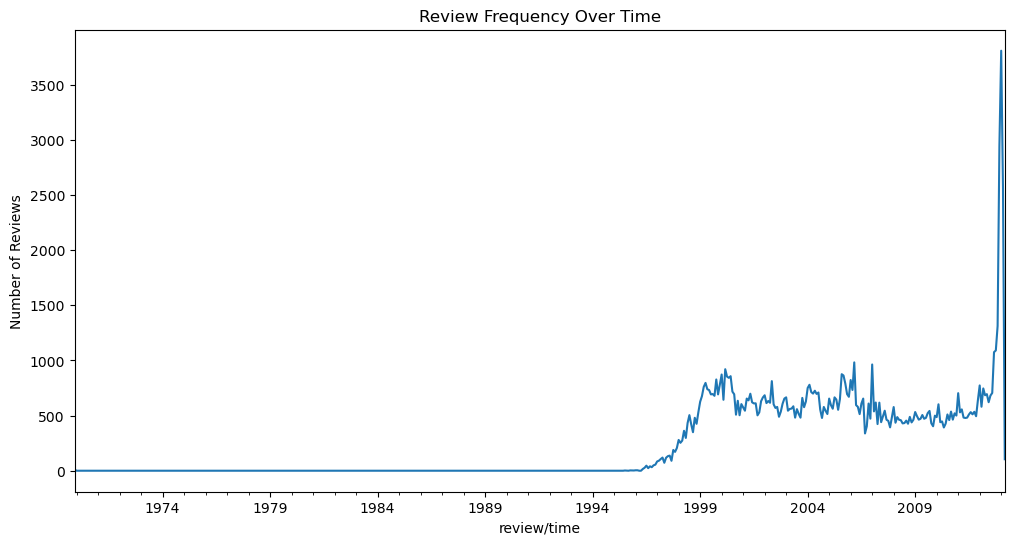

In [25]:
df['review/time'] = pd.to_datetime(df['review/time'], unit='s')
# Review trends over time
df.set_index('review/time')['Id'].resample('M').count().plot(figsize=(12, 6))
plt.title("Review Frequency Over Time")
plt.ylabel("Number of Reviews")
plt.show()

In [16]:
#create a bestseller category 
# Split the helpfulness column into two numbers (helpful votes / total votes)
df[['helpful_votes', 'total_votes']] = df['review/helpfulness'].str.split('/', expand=True).astype(int)

# Define bestseller criteria
df['bestseller'] = df.apply(lambda row: "Yes" if row['review/score'] >= 4.5 and row['total_votes'] >= 10 else "No", axis=1)

# Display result
df.head()

,Id,Title,review/helpfulness,review/score,review/time,review/summary,review/text,helpful_votes,total_votes,helpfulness_ratio,sentiment,bestseller
0,1882931173,Its Only Art If Its Well Hung!,7/7,4.0,1999-10-23,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...,7,7,1.000000,0.9408,No
1,0826414346,Dr. Seuss: American Icon,10/10,5.0,2004-09-21,Really Enjoyed It,I don't care much for Dr. Seuss but after read...,10,10,1.000000,0.9876,Yes
2,0826414346,Dr. Seuss: American Icon,10/11,5.0,2004-03-09,Essential for every personal and Public Library,"If people become the books they read and if ""t...",10,11,0.909091,0.9935,Yes
3,0826414346,Dr. Seuss: American Icon,7/7,4.0,2004-07-25,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",7,7,1.000000,0.9807,No
4,0826414346,Dr. Seuss: American Icon,3/3,4.0,2005-02-10,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...,3,3,1.000000,0.9803,No


In [17]:
print(list(df.columns))

['Id', 'Title', 'review/helpfulness', 'review/score', 'review/time', 'review/summary', 'review/text', 'helpful_votes', 'total_votes', 'helpfulness_ratio', 'sentiment', 'bestseller']


In [18]:
# Data preprocessing
# Convert bestseller to binary
df['bestseller_binary'] = df['bestseller'].map({'Yes': 1, 'No': 0})

In [19]:
# Process review helpfulness to extract ratio
def extract_helpfulness_ratio(help_str):
    numerator, denominator = map(int, help_str.split('/'))
    return numerator / denominator if denominator > 0 else 0

df['helpfulness_ratio'] = df['review/helpfulness'].apply(extract_helpfulness_ratio)

# Convert review/time to datetime and then extract features
df['review_date'] = pd.to_datetime(df['review/time'])
df['review_year'] = df['review_date'].dt.year
df['review_month'] = df['review_date'].dt.month
df['days_since_2000'] = (df['review_date'] - pd.Timestamp('2000-01-01')).dt.days


In [20]:
# Feature Engineering
# Unique title ratio (might indicate if a book has multiple reviews)
title_counts = df['Title'].value_counts()
df['title_uniqueness'] = df['Title'].map(lambda x: 1 / title_counts[x])

# Engagement metrics
df['vote_ratio'] = df['helpful_votes'] / df['total_votes'].replace(0, 1)  # Avoid division by zero

# Feature selection
# Numeric features
num_features = [
    'review/score', 
    'sentiment', 
    'helpful_votes', 
    'total_votes',
    'helpfulness_ratio', 
    'review_year',
    'review_month',
    'days_since_2000',
    'title_uniqueness',
    'vote_ratio'
]

X_numeric = df[num_features]


In [21]:
# Text features
title_vectorizer = TfidfVectorizer(max_features=50, stop_words='english')
summary_vectorizer = TfidfVectorizer(max_features=50, stop_words='english')
text_vectorizer = TfidfVectorizer(max_features=100, stop_words='english')

X_title = title_vectorizer.fit_transform(df['Title'])
X_summary = summary_vectorizer.fit_transform(df['review/summary'])
X_text = text_vectorizer.fit_transform(df['review/text'])

# Combine all features
X_combined = hstack([X_numeric, X_title, X_summary, X_text])
y = df['bestseller_binary'].values

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)


In [22]:
#SVM pipeline
svm_pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),  # with_mean=False for sparse data
    ('svm', SVC(probability=True, class_weight='balanced'))
])

# Then define the parameter grid
param_grid = {
    'svm__C': [1, 10],           # Reduced from 4 values to 2
    'svm__kernel': ['linear'],   # Focus on linear kernel which is faster
    'svm__gamma': ['scale']      # Only use scale which is usually better
}

# Now create the grid search
grid_search = GridSearchCV(
    svm_pipeline, 
    param_grid, 
    cv=3,            # Keep 3-fold CV
    scoring='f1',
    n_jobs=4,        # Limit to 4 parallel jobs to avoid memory issues
    verbose=2        # Add verbosity to see progress
)

# Finally, fit the model
grid_search.fit(X_train, y_train)



Fitting 3 folds for each of 2 candidates, totalling 6 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('svm',
                                        SVC(class_weight='balanced',
                                            probability=True))]),
             n_jobs=4,
             param_grid={'svm__C': [1, 10], 'svm__gamma': ['scale'],
                         'svm__kernel': ['linear']},
             scoring='f1', verbose=2)

In [26]:
# Print results
print(f"Best parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

# Evaluate on test set
y_pred = best_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))



Best parameters: {'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     21431
           1       0.76      1.00      0.86      1951

    accuracy                           0.97     23382
   macro avg       0.88      0.99      0.92     23382
weighted avg       0.98      0.97      0.97     23382


Confusion Matrix:
[[20806   625]
 [    0  1951]]


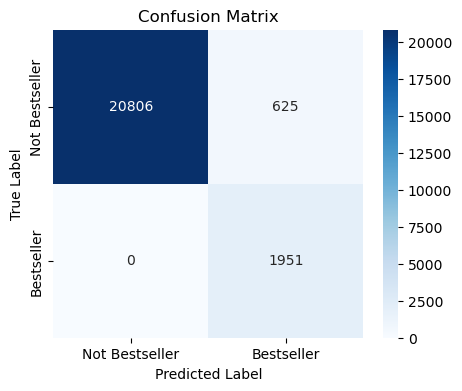

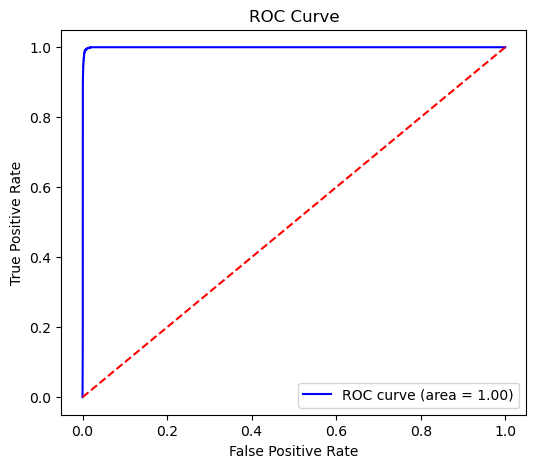

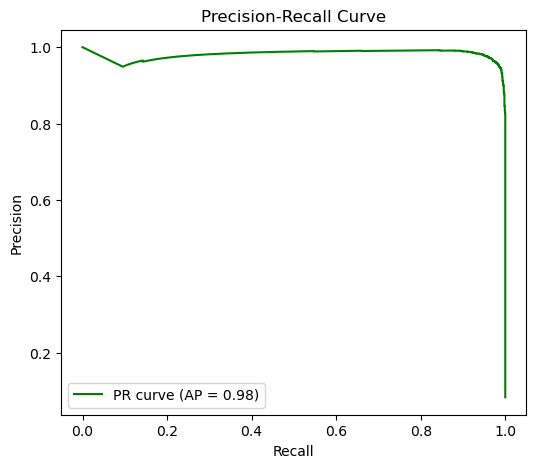

In [28]:

# Confusion Matrix Heatmap
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Bestseller', 'Bestseller'], yticklabels=['Not Bestseller', 'Bestseller'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# ROC Curve
def plot_roc_curve(y_test, y_scores):
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'r--')  # Dashed diagonal
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Precision-Recall Curve
def plot_precision_recall_curve(y_test, y_scores):
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    avg_precision = average_precision_score(y_test, y_scores)

    plt.figure(figsize=(6,5))
    plt.plot(recall, precision, color='green', label=f'PR curve (AP = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

# Get predicted probabilities
y_scores = best_model.predict_proba(X_test)[:, 1]

# Plot results
plot_confusion_matrix(y_test, y_pred)
plot_roc_curve(y_test, y_scores)
plot_precision_recall_curve(y_test, y_scores)